# Introduction - Problem Statement & Understanding

IT functions are the most important engine to enable, maintain and monitor the daily business activities in an organization. The more scalable the company is, the more IT systems would be engaged on a daily basis. In accordance, a larger IT support team is needed to support and make sure of all the IT systems to work as expected. Whenever users encounter an issue/incident, they will raise a ticket through online portal for IT team to help resolve.

The tickets come from:


*   Business Users
*   IT Users
*   Monitorig tools



The tickets shall be resolved by:
* L1/L2 team - basic functional advisory / resolution
* Functional teams (L3) - escalated issue resolution / vendor contact

As the business scale up and number of employees grows, below concerns would occur in above process:
* It is time-consuming to mannually perform ticket allocation
* It is costly to hire more workforces to perform this allocation
* There will be unavoidable mistakes in this allocation due to operational risk / lack of knowledge / subjective understanding, etc.
* Bad employee user experience due to above three concerns

## Need of Project & Social Opportunities

What we are trying to do here is to understand the landscape of ticket  allocation process and come up with an NLP-based algorithm to intelligently classify the tickets timely to the right team and person. The benefits include:
* Minimizes wasted time on mannual allocation
* Saves cost to hire more workforces on mannual allocation
* Minimizes mistakes caused by operational risk (because it will be automated) and subjective understanding / lack of knowledge (because the algorithm will be consistently applied)
* Enhances user experience by timely resolve their issues properly hence improves the business growth.

Social Opportunities:
* All organization are seeking full automation in support functions. Basic data transportation could be done by RPA, but RPA does not have intelligence and cannot handle unstructured data. Embedding this algorithm would solve this problem by handling unstructured data with intelligence, hence integrated with RPA to achieve end-to-end automation.
* This is a highly replicable business case where we can parallelly seek business opportunities to sell to a wide variety of customers on the market. Basic tickets are all similar. We can sell it as a cloud-based AI fabric.

# Data Report - Understanding the dataset

Upload and read the file to display the first few rows.

In [ ]:
import os
import numpy as np  
import pandas as pd
from google.colab import files
import nltk
from nltk.corpus import stopwords  
from nltk.stem import PorterStemmer 
from sklearn.feature_extraction.text import CountVectorizer          #For Bag of words
from sklearn.feature_extraction.text import TfidfVectorizer          #For TF-IDF
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D, SpatialDropout1D
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
import io
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as stat

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
uploaded = files.upload()

Saving input_data.xlsx to input_data (1).xlsx


In [ ]:
df = pd.read_excel(io.BytesIO(uploaded["input_data.xlsx"]))

Now let's explore, starting with checking the first few rows of the dataset. Each row represents 1 ticket. For each ticket, there are 4 colums of data:
* Short description - a short summary of the whole issue. In some organizations, this data comes from a pre-defined dropdown list to narrow down the value range - not sure whether in this case, we will explore later. Some very simple and basic issues can be directly allocated according to short description without reading full description.
* Description - Full description from the raiser of the ticket. Further information and details are provided here to decide on the allocation. 
* Caller - ticket raiser. From a very basic perspective, this column does not have a big impact on the allocation because they are simply the names of users. There are exceptions eg. for certain group of users all tickets are allocated to one functional group. We will explore whether it is the case here before deciding on whether to drop the column.
* Assignment group - the target variable. Indicates to which group is the ticket allocated to. It is the final classfication decision we need to predict.

In [ ]:
df.head(10)

Short description  ... Assignment group
0  login issue                                                                                                ...  GRP_0          
1  outlook                                                                                                    ...  GRP_0          
2  cant log in to vpn                                                                                         ...  GRP_0          
3  unable to access hr_tool page                                                                              ...  GRP_0          
4  skype error                                                                                                ...  GRP_0          
5  unable to log in to engineering tool and skype                                                             ...  GRP_0          
6  event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/   ...  GRP_1          
7  ticket_no1550391- employment status - new non-employee [enter user's name]                                 ...  GRP_0          
8  unable to disable add ins on outlook                                                                       ...  GRP_0          
9  ticket update on inplant_874773                                                                            ...  GRP_0          

[10 rows x 4 columns]

We can basically understand the methodology of data collection according to above display. The tickets are riased on a real-time basis whenever the users encounter issue and decide to raise a ticket. Each user can raise as many tickets as they want to. This dataset is probably the historical data for the past month. 

Check the shape of the dataset: There are 8500 entities and 4 columns in total.

In [ ]:
df.shape

(8500, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


Now let's see the data structure of each colume. Count indicates non-null values. As we can see, Caller and Assignment group do not have missing values; Short description has 8 missing values and Description has 1 missing value. We need to handle them properly.

Unique indicates unique values of each column. As we can see, Short description has 7k+ unique values, so it answers the question that short description is most likely edited by users instead of selected from a pre-defined dropdown list. We can also see that there are 74 assignment groups in total, and almost half of the tickets are allocated to GRP_0.

Caller bpctwhsn kzqsbmtp raised 810 tickets, we need to check on potential duplicates.

In [ ]:
df.describe(include="all")

Short description Description             Caller Assignment group
count   8492              8499        8500               8500           
unique  7481              7817        2950               74             
top     password reset    the         bpctwhsn kzqsbmtp  GRP_0          
freq    38                56          810                3976

In [ ]:
print(df.isnull().any(axis = 0))

Short description    True 
Description          True 
Caller               False
Assignment group     False
dtype: bool


Above code verifies above statement "Caller and Assignment group do not have missing values; Short description has 8 missing values and Description has 1 missing value".

In [ ]:
df['Assignment group'].value_counts()

GRP_0     3976
GRP_8     661 
GRP_24    289 
GRP_12    257 
GRP_9     252 
GRP_2     241 
GRP_19    215 
GRP_3     200 
GRP_6     184 
GRP_13    145 
GRP_10    140 
GRP_5     129 
GRP_14    118 
GRP_25    116 
GRP_33    107 
GRP_4     100 
GRP_29    97  
GRP_18    88  
GRP_16    85  
GRP_17    81  
GRP_31    69  
GRP_7     68  
GRP_34    62  
GRP_26    56  
GRP_40    45  
GRP_28    44  
GRP_41    40  
GRP_15    39  
GRP_30    39  
GRP_42    37  
GRP_20    36  
GRP_45    35  
GRP_1     31  
GRP_22    31  
GRP_11    30  
GRP_21    29  
GRP_47    27  
GRP_62    25  
GRP_23    25  
GRP_48    25  
GRP_60    20  
GRP_39    19  
GRP_27    18  
GRP_37    16  
GRP_36    15  
GRP_44    15  
GRP_50    14  
GRP_53    11  
GRP_65    11  
GRP_52    9   
GRP_55    8   
GRP_51    8   
GRP_49    6   
GRP_59    6   
GRP_46    6   
GRP_43    5   
GRP_66    4   
GRP_32    4   
GRP_56    3   
GRP_63    3   
GRP_68    3   
GRP_38    3   
GRP_58    3   
GRP_71    2   
GRP_69    2   
GRP_72    2   
GRP_54    

Above code verifies the statement "We can also see that there are 74 assignment groups in total, and almost half of the tickets are allocated to GRP_0."

Now let's display the tickets with null values to see how to handle.

In [ ]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [ ]:
df[df.isnull().any(axis=1)]

Short description  ... Assignment group
2604  NaN                       ...  GRP_34         
3383  NaN                       ...  GRP_0          
3906  NaN                       ...  GRP_0          
3910  NaN                       ...  GRP_0          
3915  NaN                       ...  GRP_0          
3921  NaN                       ...  GRP_0          
3924  NaN                       ...  GRP_0          
4341  NaN                       ...  GRP_0          
4395  i am locked out of skype  ...  GRP_0          

[9 rows x 4 columns]

In a long term, we can advise to improvise the ticket portal - make both fields Short description & Description mandatory fields when users submit tickets. 

For this project, I would advise to remove these tickets with null values. Reason being they are string values, any replacement / refilling decided by me would be subjective and will impact the prediction.

In [ ]:
df = df.dropna()

In [ ]:
df.shape

(8491, 4)

Now let's check on this particular user with 810 tickets raised. Check whether this is a system error or duplicate.

In [ ]:
df.loc[df['Caller'] == 'bpctwhsn kzqsbmtp']

Short description  ... Assignment group
47    job Job_1424 failed in job_scheduler at: 10/31/2016 09:06:00                                   ...  GRP_6          
50    job mm_zscr0099_dly_merktc3 failed in job_scheduler at: 10/31/2016 08:36:00                    ...  GRP_8          
59    job mm_zscr0099_dly_merktc2 failed in job_scheduler at: 10/31/2016 05:19:00                    ...  GRP_8          
60    job Job_3181 failed in job_scheduler at: 10/31/2016 05:00:00                                   ...  GRP_8          
67    job Job_1338 failed in job_scheduler at: 10/31/2016 02:29:00                                   ...  GRP_9          
68    job Job_1854 failed in job_scheduler at: 10/31/2016 01:36:00                                   ...  GRP_8          
69    job Job_2588 failed in job_scheduler at: 10/31/2016 01:30:00                                   ...  GRP_8          
70    job Job_2599 failed in job_scheduler at: 10/31/2016 01:30:00                                   ...  GRP_8          
75    job hr_payroll_na_u1 failed in job_scheduler at: 10/30/2016 23:00:00                           ...  GRP_10         
76    job hr_payroll_na_u2 failed in job_scheduler at: 10/30/2016 23:00:00                           ...  GRP_10         
77    job hr_payroll_na_u6 failed in job_scheduler at: 10/30/2016 23:00:00                           ...  GRP_10         
80    job Job_1424 failed in job_scheduler at: 10/30/2016 10:35:00                                   ...  GRP_6          
83    job bwhrattr failed in job_scheduler at: 10/30/2016 02:20:00                                   ...  GRP_9          
85    job apo_bop_plant_283a failed in job_scheduler at: 10/30/2016 01:25:00                         ...  GRP_6          
86    job Job_1315 failed in job_scheduler at: 10/30/2016 00:48:00                                   ...  GRP_9          
87    job mm_zscr0099_wkly_rollfgyuej1 failed in job_scheduler at: 10/30/2016 00:11:00               ...  GRP_8          
89    job Job_3050 failed in job_scheduler at: 10/29/2016 23:02:00                                   ...  GRP_8          
90    job SID_30cold failed in job_scheduler at: 10/29/2016 18:58:00                                 ...  GRP_5          
91    job SID_35cold failed in job_scheduler at: 10/29/2016 18:47:00                                 ...  GRP_5          
92    job Job_436 failed in job_scheduler at: 10/29/2016 18:29:00                                    ...  GRP_5          
93    job SID_29cold failed in job_scheduler at: 10/29/2016 18:11:00                                 ...  GRP_5          
94    job Job_717 failed in job_scheduler at: 10/29/2016 18:11:00                                    ...  GRP_5          
95    job SID_26cold failed in job_scheduler at: 10/29/2016 18:11:00                                 ...  GRP_5          
96    job SID_35cold failed in job_scheduler at: 10/29/2016 18:09:00                                 ...  GRP_5          
102   job Job_1390 failed in job_scheduler at: 10/29/2016 03:55:00                                   ...  GRP_9          
103   job Job_2002 failed in job_scheduler at: 10/29/2016 02:52:00                                   ...  GRP_8          
104   job Job_2002 failed in job_scheduler at: 10/29/2016 02:30:00                                   ...  GRP_6          
105   job Job_1319 failed in job_scheduler at: 10/29/2016 02:02:00                                   ...  GRP_9          
106   job Job_1382 failed in job_scheduler at: 10/29/2016 02:00:00                                   ...  GRP_9          
112   job Job_2881 failed in job_scheduler at: 10/28/2016 18:06:00                                   ...  GRP_13         
137   job Job_1854 failed in job_scheduler at: 10/28/2016 11:06:00                                   ...  GRP_8          
138   job Job_1879 failed in job_scheduler at: 10/28/2016 11:01:00                                   ...  GRP_8          
156   job bkbackup_tool_sql_prod_inc failed in job_sched

As we can see, this user raised a number of tickets regarding failure in job scheduler. It is raised at different points of time, and his tickets are assigned to different groups. Hence this person may work in Operations Monitor/Scheduling Center, and his tickets are sensible from business perspective. We will leave it as it is.

## Initial EDA - Make Sense of the Data

In [ ]:
df['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

There are 74 groups in total. We have printed all the names, they are named GRP_NUMBER with NUMBER from 0 to 73.

We already have this from above code to know that most cases are assigned to GRP_0, and there are groups that only get 1 ticket.

**Below steps are added in Project Notes 3 - All duplicates are supposed to be dropped, then plot added for visualization**

In [ ]:
new_df = df.drop_duplicates(['Short description', 'Description', 'Caller', 'Assignment group'])

In [ ]:
new_df.shape

(8408, 4)

In [ ]:
pd.set_option('display.max_rows', None)
new_df['Assignment group'].value_counts()

GRP_0     3926
GRP_8     645 
GRP_24    285 
GRP_12    257 
GRP_9     252 
GRP_2     241 
GRP_19    215 
GRP_3     200 
GRP_6     183 
GRP_13    145 
GRP_10    140 
GRP_5     128 
GRP_14    118 
GRP_25    116 
GRP_33    107 
GRP_4     100 
GRP_29    97  
GRP_18    88  
GRP_16    85  
GRP_31    69  
GRP_17    68  
GRP_7     68  
GRP_34    61  
GRP_26    56  
GRP_40    45  
GRP_28    44  
GRP_41    40  
GRP_30    39  
GRP_15    38  
GRP_42    37  
GRP_20    36  
GRP_45    35  
GRP_1     31  
GRP_22    31  
GRP_11    30  
GRP_21    28  
GRP_47    27  
GRP_62    25  
GRP_23    25  
GRP_48    25  
GRP_39    19  
GRP_27    18  
GRP_37    16  
GRP_60    16  
GRP_36    15  
GRP_44    15  
GRP_50    14  
GRP_53    11  
GRP_65    11  
GRP_52    9   
GRP_55    8   
GRP_51    8   
GRP_49    6   
GRP_59    6   
GRP_46    6   
GRP_43    5   
GRP_66    4   
GRP_32    4   
GRP_56    3   
GRP_63    3   
GRP_68    3   
GRP_38    3   
GRP_58    3   
GRP_71    2   
GRP_69    2   
GRP_72    2   
GRP_54    

In [ ]:
df_grp = new_df.groupby(['Assignment group']).size().reset_index(name='counts')
df_grp

Assignment group  counts
0   GRP_0            3926  
1   GRP_1            31    
2   GRP_10           140   
3   GRP_11           30    
4   GRP_12           257   
5   GRP_13           145   
6   GRP_14           118   
7   GRP_15           38    
8   GRP_16           85    
9   GRP_17           68    
10  GRP_18           88    
11  GRP_19           215   
12  GRP_2            241   
13  GRP_20           36    
14  GRP_21           28    
15  GRP_22           31    
16  GRP_23           25    
17  GRP_24           285   
18  GRP_25           116   
19  GRP_26           56    
20  GRP_27           18    
21  GRP_28           44    
22  GRP_29           97    
23  GRP_3            200   
24  GRP_30           39    
25  GRP_31           69    
26  GRP_32           4     
27  GRP_33           107   
28  GRP_34           61    
29  GRP_35           1     
30  GRP_36           15    
31  GRP_37           16    
32  GRP_38           3     
33  GRP_39           19    
34  GRP_4            100   
35  GRP_40           45    
36  GRP_41           40    
37  GRP_42           37    
38  GRP_43           5     
39  GRP_44           15    
40  GRP_45           35    
41  GRP_46           6     
42  GRP_47           27    
43  GRP_48           25    
44  GRP_49           6     
45  GRP_5            128   
46  GRP_50           14    
47  GRP_51           8     
48  GRP_52           9     
49  GRP_53           11    
50  GRP_54           2     
51  GRP_55           8     
52  GRP_56           3     
53  GRP_57           2     
54  GRP_58           3     
55  GRP_59           6     
56  GRP_6            183   
57  GRP_60           16    
58  GRP_61           1     
59  GRP_62           25    
60  GRP_63           3     
61  GRP_64           1     
62  GRP_65           11    
63  GRP_66           4     
64  GRP_67           1     
65  GRP_68           3     
66  GRP_69           2     
67  GRP_7            68    
68  GRP_70           1     
69  GRP_71           2     
70  GRP_72           2     
71  GRP_73           1     
72  GRP_8            645   
73  GRP_9            252

In [ ]:
new_df.describe()

Short description Description             Caller Assignment group
count   8408              8408        8408               8408           
unique  7480              7812        2948               74             
top     password reset    the         bpctwhsn kzqsbmtp  GRP_0          
freq    38                43          788                3926

Now let's take a look based on each group and try to get some insight.

In [ ]:
sns.set_style("darkgrid")
## distibution based on Percentage
df_grp["count_perc"] = round((df_grp["counts"]/new_df.shape[0])*100,2)
df_grp.sort_values(["count_perc"], axis=0, 
                 ascending=False, inplace=True) 

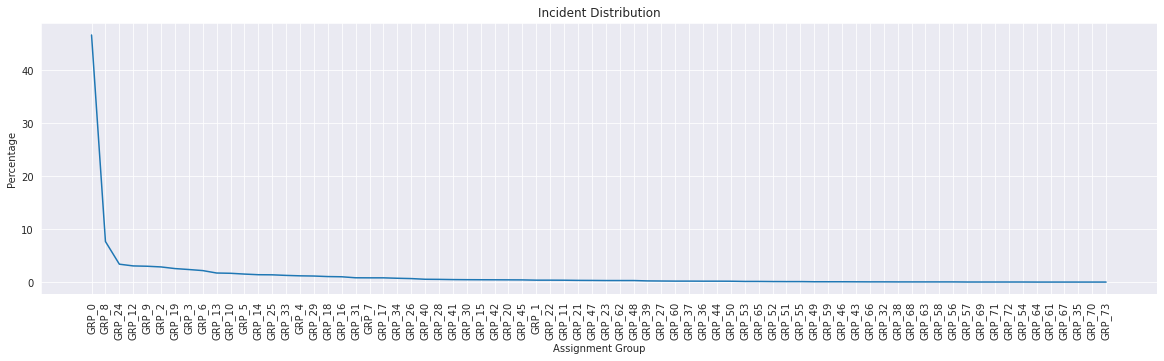

In [ ]:
plt.subplots(figsize = (20,5))
 
plt.plot(df_grp["Assignment group"], df_grp["count_perc"]) 
plt.xlabel('Assignment Group') 
plt.ylabel('Percentage') 
plt.xticks(rotation=90)
plt.title('Incident Distribution') 
  
 
plt.show() 

In [ ]:
new_df.loc[new_df['Assignment group'] == 'GRP_0']

Short description  ... Assignment group
0     login issue                                                                                                                                                      ...  GRP_0          
1     outlook                                                                                                                                                          ...  GRP_0          
2     cant log in to vpn                                                                                                                                               ...  GRP_0          
3     unable to access hr_tool page                                                                                                                                    ...  GRP_0          
4     skype error                                                                                                                                                      ...  GRP_0          
5     unable to log in to engineering tool and skype                                                                                                                   ...  GRP_0          
7     ticket_no1550391- employment status - new non-employee [enter user's name]                                                                                       ...  GRP_0          
8     unable to disable add ins on outlook                                                                                                                             ...  GRP_0          
9     ticket update on inplant_874773                                                                                                                                  ...  GRP_0          
10    engineering tool says not connected and unable to submit reports                                                                                                 ...  GRP_0          
11    hr_tool site not loading page correctly                                                                                                                          ...  GRP_0          
12    unable to login to hr_tool to sgxqsuojr xwbesorf cards                                                                                                           ...  GRP_0          
13    user wants to reset the password                                                                                                                                 ...  GRP_0          
14    unable to open payslips                                                                                                                                          ...  GRP_0          
15    ticket update on inplant_874743                                                                                                                                  ...  GRP_0          
16    unable to login to company vpn                                                                                                                                   ...  GRP_0          
18    erp SID_34 account locked                                                                                                                                        ...  GRP_0          
19    unable to sign into vpn                                                                                                                                          ...  GRP_0          
20    unable to check payslips                                                                                                                                         ...  GRP_0          
21    vpn issue                                                                                                                                                        ...  GRP_0          
22    unable to connect to vpn                                                                                                                                         ...  GRP_0          
23    user c

Too many tickets assigned to GRP_0, it's difficult to make sense from scratch.

In [ ]:
new_df['Assignment group']

0       GRP_0 
1       GRP_0 
2       GRP_0 
3       GRP_0 
4       GRP_0 
5       GRP_0 
6       GRP_1 
7       GRP_0 
8       GRP_0 
9       GRP_0 
10      GRP_0 
11      GRP_0 
12      GRP_0 
13      GRP_0 
14      GRP_0 
15      GRP_0 
16      GRP_0 
17      GRP_3 
18      GRP_0 
19      GRP_0 
20      GRP_0 
21      GRP_0 
22      GRP_0 
23      GRP_0 
24      GRP_0 
25      GRP_0 
26      GRP_0 
27      GRP_0 
28      GRP_0 
29      GRP_0 
30      GRP_0 
31      GRP_0 
32      GRP_4 
33      GRP_0 
34      GRP_0 
35      GRP_0 
36      GRP_0 
37      GRP_0 
38      GRP_0 
39      GRP_0 
40      GRP_0 
41      GRP_0 
42      GRP_0 
43      GRP_5 
44      GRP_0 
45      GRP_0 
46      GRP_0 
47      GRP_6 
48      GRP_0 
49      GRP_7 
50      GRP_8 
52      GRP_0 
53      GRP_0 
54      GRP_0 
55      GRP_0 
56      GRP_0 
57      GRP_6 
58      GRP_0 
59      GRP_8 
60      GRP_8 
61      GRP_0 
62      GRP_0 
63      GRP_6 
64      GRP_8 
65      GRP_0 
66      GRP_0 
67      GR

In [ ]:
new_df.loc[new_df['Assignment group'] == 'GRP_8'].head(50)

Short description  ... Assignment group
50   job mm_zscr0099_dly_merktc3 failed in job_scheduler at: 10/31/2016 08:36:00                                ...  GRP_8          
59   job mm_zscr0099_dly_merktc2 failed in job_scheduler at: 10/31/2016 05:19:00                                ...  GRP_8          
60   job Job_3181 failed in job_scheduler at: 10/31/2016 05:00:00                                               ...  GRP_8          
64   apac company : two switches are down since 3.45 am et on 10/31.                                            ...  GRP_8          
68   job Job_1854 failed in job_scheduler at: 10/31/2016 01:36:00                                               ...  GRP_8          
69   job Job_2588 failed in job_scheduler at: 10/31/2016 01:30:00                                               ...  GRP_8          
70   job Job_2599 failed in job_scheduler at: 10/31/2016 01:30:00                                               ...  GRP_8          
78   power outage:UK al, 1st and 5th ave sites hard down since at 4:31 pm et on 10/30.                          ...  GRP_8          
79   power outage : germany, mx: site is hard down since 10/30/2016 10:09 am et                                 ...  GRP_8          
87   job mm_zscr0099_wkly_rollfgyuej1 failed in job_scheduler at: 10/30/2016 00:11:00                           ...  GRP_8          
89   job Job_3050 failed in job_scheduler at: 10/29/2016 23:02:00                                               ...  GRP_8          
103  job Job_2002 failed in job_scheduler at: 10/29/2016 02:52:00                                               ...  GRP_8          
137  job Job_1854 failed in job_scheduler at: 10/28/2016 11:06:00                                               ...  GRP_8          
138  job Job_1879 failed in job_scheduler at: 10/28/2016 11:01:00                                               ...  GRP_8          
142  usa - (company) : interface fastethernet0/16 & gigabitethernet1/0/18 is down since  09:23 pm et on 09/28.  ...  GRP_8          
156  job bkbackup_tool_sql_prod_inc failed in job_scheduler at: 10/28/2016 07:41:00                             ...  GRP_8          
166  job Job_593 failed in job_scheduler at: 10/28/2016 04:11:00                                                ...  GRP_8          
171  job Job_495 failed in job_scheduler at: 10/28/2016 03:12:00                                                ...  GRP_8          
172  job Job_481 failed in job_scheduler at: 10/28/2016 02:51:00                                                ...  GRP_8          
182  job Job_1854 failed in job_scheduler at: 10/28/2016 01:36:00                                               ...  GRP_8          
188  job bkwin_HostName_770_inc failed in job_scheduler at: 10/27/2016 22:08:00                                 ...  GRP_8          
189  network outage: india: site hard down since at 8:34 pm et on 10/27. no backup circuit.                     ...  GRP_8          
215  network outage  - warehouse: node company-ups-vpn-rtr is down 10/27/2016 9:54 am                           ...  GRP_8          
224  job pp_EU_tool_netch_ap1 failed in job_scheduler at: 10/27/2016 09:54:00                                   ...  GRP_8          
240  power outage :australia australia: site hard down since at 7.31am et on 10/27.                             ...  GRP_8          
246  job Job_2668 failed in job_scheduler at: 10/27/2016 06:06:00                                               ...  GRP_8          
267  job Job_1854 failed in job_scheduler at: 10/27/2016 01:36:00                                               ...  GRP_8          
269  job Job_2584 failed in job_scheduler at: 10/27/2016 01:30:00                                               ...  GRP_8          
283  network outage: , india: site hard down since at 7:23 pm et at 10/26. no backup circuit.                   ...  GRP_8          
291  india:  29060s-access-sw01 and sw02 went down at 02:12 pm et on 10/26.                            

As above, I printed out 50 tickets assigned to GRP_8. We can make a wild guess that two types of tickets are assigned:
* Job-scheduling failures
* Circuit outage / network issues globally (We saw Germany and India)

In [ ]:
new_df.loc[new_df['Assignment group'] == 'GRP_24'].head(50)

Short description  ... Assignment group
222   support fÃ¼r fa.gstry \arexjftu ohxdwngl                                                          ...  GRP_24         
223   probleme mit bluescreen .                                                                         ...  GRP_24         
255   probleme mit laufwerk z: \laeusvjo fvaihgpx                                                       ...  GRP_24         
302   EU_tool ist sehr langsadgtym \ywqgrbnx jwnsyzbv \jionmpsf wnkpzcmv                                ...  GRP_24         
304   alte eq abholen \wrcktgbd wzrgyunp                                                                ...  GRP_24         
305   probleme lan an tgeyd1 \we_wu113 \wrcktgbd wzrgyunp                                               ...  GRP_24         
306   support fÃ¼r we111\zlqfptjx xnklbfua                                                              ...  GRP_24         
349   install EU_tool \laeusvjo fvaihgpx                                                                ...  GRP_24         
441   probleme mit portal \knlrgsiv cqvuexjz                                                            ...  GRP_24         
446   setup rechner ewel8323865 fÃ¼r hr.thrydad (thrydad consulting ) \puxsvfwr cwkjruni                ...  GRP_24         
453   probleme mit erpgui \tmqfjard qzhgdoua                                                            ...  GRP_24         
454   support fÃ¼r fa.thrydsss-funke \laeusvjo fvaihgpx                                                 ...  GRP_24         
455   bildband  tauschen \drucker we68678 \vepxdgot poezmwny                                            ...  GRP_24         
555   probleme mit fixiereinheit we101 \qvncizuf ueiybanz                                               ...  GRP_24         
586   probleme mit bluescreen                                                                           ...  GRP_24         
589   probleme mit lan fÃ¼r rechner erodiermaschine\ dtlmbcrx mwuateyx                                  ...  GRP_24         
744   drucker in lÃ¶we uacyltoe hxgayczeraum knicrhtyt papier \dtlmbcrx mwuateyx                        ...  GRP_24         
748   reinstall hardcopy und EU_tool \lndypaqg dhqwtcsr                                                 ...  GRP_24         
751   we111 gibt nur eine fehlermeldung aus                                                             ...  GRP_24         
757   rechner fÃ¼r lÃ¤ngenmessmaschine uacyltoe hxgayczeen \xosdfhbu gtbfkisl                           ...  GRP_24         
761   kabel lan 10m liefern \gogtyekhan merdivan                                                        ...  GRP_24         
769   backup fÃ¼r rechner  lasplant_119\pfjwinbg ljtzbdqg                                               ...  GRP_24         
887   support fÃ¼r roboworker \sandstrahlen \xwirzvda okhyipgr                                          ...  GRP_24         
888   setup new ws \lndypaqg dhqwtcsr                                                                   ...  GRP_24         
904   probleme mit barcode etiketten \volume format zu groÃŸ \vzqomdgt jwoqbuml                         ...  GRP_24         
905   setup new ws in br \usalikfj lfmpxbcn                                                             ...  GRP_24         
906   der monitor an unser lÃ¤ngenmessmaschine ist defekt .                                             ...  GRP_24         
993   bitte scanner fÃ¼r we111 einstellen.drucker wurde auf werkseinstellung zurÃ¼ckgesetzt (konica ).  ...  GRP_24         
997   probleme mit login in br \usalikfj lfmpxbcn                                                       ...  GRP_24         
1034  lÃ¼fter defekt \industriekontrollmonitor \niptbwdq csenjruz                                       ...  GRP_24         
1035  reinstall win7 \qidgvtwa qvbutayx                                                                 ...  GRP_24         
1036  probleme mit kamera und monitor .                                              

We can see that all tickets are in German (looks like). Hence we can infer that GRP_24 is supporting issues raised in Germany / by German users.

In [ ]:
new_df.loc[new_df['Assignment group'] == 'GRP_12'].head(50)

Short description  ... Assignment group
97    amssm00345: c:\ label:sys-amssm00345 94ef9088 on server: is over  85% space consumed. space available: 2.7 g                    ...  GRP_12         
175   job Job_487 failed in job_scheduler at: 10/28/2016 02:06:00                                                                     ...  GRP_12         
278   sn 04os20400001808 has been identified as unavailable via esrs monitoring services and you may have no esrs connectivity        ...  GRP_12         
336   data back up for germany                                                                                                        ...  GRP_12         
337   server ekpsm005678 located at germany location is down since 2:27am on 10/15/16                                                 ...  GRP_12         
350   access to  m:\live\mw_live(HostName_95)                                                                                         ...  GRP_12         
353   HostName_19 : volume c:\  disk consumed is 85% .                                                                                ...  GRP_12         
355   HostName_1035(bobj): cpu load on server is high currently utilization is 100% since 3:57am on 10/26/16                          ...  GRP_12         
411   cannot open excel files from \\HostName_1351\departments\hrm pricing\current pricing\fy17 and bkzcfmse naslrwdb can.            ...  GRP_12         
470   access to s drive.                                                                                                              ...  GRP_12         
474   HostName_1030 is currently experiencing high cpu utilization. please investigate!                                               ...  GRP_12         
478   access to //HostName_95/departments/backorderreports                                                                            ...  GRP_12         
488   çœ‹ä¸è§a3 çš„æ–‡ä»¶å¤¹ï¼ˆ\\HostName_17\teams\business\ a3 ï¼‰ï¼Œè¯·å¸®å¿™å¼„ä¸€ä¸‹ã€‚sahtym wanthryg                          ...  GRP_12         
510   usa file server, HostName_1326, has failed hard drive                                                                           ...  GRP_12         
517   the username ccghksdm787 will be used to login to company via citrix                                                            ...  GRP_12         
647   HostName_587: germany server is down since 11:01 am  et on 10/23.                                                               ...  GRP_12         
654   HostName_1013 does not come up after weekly reboot                                                                              ...  GRP_12         
674   HostName_804: c:\ disk volume is over 85% space consumed.                                                                       ...  GRP_12         
813   folder access required                                                                                                          ...  GRP_12         
831   files on servers not available.  files cannot be opened.HostName_1326                                                           ...  GRP_12         
836   citrix access.                                                                                                                  ...  GRP_12         
856   bdwdwarbara needs the permissions to save to the folder (srvlavstorage01)( j):toolroom/tooling documentation                    ...  GRP_12         
857   needs access to server \\HostName_852\drafting\itar  to the user-wdwddw wwdyuan(yqddquanw), read only access                    ...  GRP_12         
884   bitte user gogtyektdgwo richtig einstellen .nach anmeldung fehlen alle netzlaufwerke                                            ...  GRP_12         
899   HostName_1030 is currently experiencing high cpu utilization. please investigate!                                               ...  GRP_12         
909   restore                                                                        

We can guess that GRP_12 mainly handles disk / hardware / file corruption or loss, as well as CPU utilization issues.

In [ ]:
new_df.loc[new_df['Assignment group'] == 'GRP_9'].head(50)

Short description  ... Assignment group
67    job Job_1338 failed in job_scheduler at: 10/31/2016 02:29:00                            ...  GRP_9          
83    job bwhrattr failed in job_scheduler at: 10/30/2016 02:20:00                            ...  GRP_9          
86    job Job_1315 failed in job_scheduler at: 10/30/2016 00:48:00                            ...  GRP_9          
102   job Job_1390 failed in job_scheduler at: 10/29/2016 03:55:00                            ...  GRP_9          
105   job Job_1319 failed in job_scheduler at: 10/29/2016 02:02:00                            ...  GRP_9          
106   job Job_1382 failed in job_scheduler at: 10/29/2016 02:00:00                            ...  GRP_9          
262   reporting_tool erp hana error                                                           ...  GRP_9          
263   job bwhrattr failed in job_scheduler at: 10/27/2016 02:25:00                            ...  GRP_9          
317   new team details not updated on bobj reports from ess                                   ...  GRP_9          
366   job bwhrattr failed in job_scheduler at: 10/26/2016 02:10:00                            ...  GRP_9          
419   recall: incident ticket_no1563995 has been assigned to oncidblt ucewizyd                ...  GRP_9          
451   sales manager views in business objects explorer                                        ...  GRP_9          
457   bobj access not working                                                                 ...  GRP_9          
458   bobj access for sales managers                                                          ...  GRP_9          
480   job Job_1330 failed in job_scheduler at: 10/25/2016 00:12:00                            ...  GRP_9          
536   could not use bobjee application: search and explorer analytics / erp netweaver portal  ...  GRP_9          
603   job Job_1390 failed in job_scheduler at: 10/24/2016 02:43:00                            ...  GRP_9          
604   job Job_1338 failed in job_scheduler at: 10/24/2016 02:21:00                            ...  GRP_9          
642   job Job_2114 failed in job_scheduler at: 10/23/2016 17:32:00                            ...  GRP_9          
652   job bwhrerattr failed in job_scheduler at: 10/23/2016 06:06:00                          ...  GRP_9          
675   job bwdpmbkp failed in job_scheduler at: 10/22/2016 12:58:00                            ...  GRP_9          
754   trigger loads for bw - fill rate recovery-kba for oct 19th 2016                         ...  GRP_9          
883   job Job_1309 failed in job_scheduler at: 83.69.48.194 07:16:00                          ...  GRP_9          
910   job Job_1378 failed in job_scheduler at: 83.69.48.194 04:28:00                          ...  GRP_9          
918   job Job_1388 failed in job_scheduler at: 83.69.48.194 03:26:00                          ...  GRP_9          
940   job Job_1315 failed in job_scheduler at: 10/19/2016 18:15:00                            ...  GRP_9          
977   job Job_1318 failed in job_scheduler at: 10/19/2016 10:40:00                            ...  GRP_9          
1024  not able to open the existing hana report                                               ...  GRP_9          
1106  bex is not responding                                                                   ...  GRP_9          
1211  analysis not working to run my quote reports. it is not showing in my tool bar.         ...  GRP_9          
1238  push-out reports                                                                        ...  GRP_9          
1259  job Job_1142 failed in job_scheduler at: 10/17/2016 06:06:00                            ...  GRP_9          
1280  job Job_1332 failed in job_scheduler at: 10/17/2016 02:26:00                            ...  GRP_9          
1311  job Job_2114 failed in job_scheduler at: 10/16/2016 17:31:00                            ...  GRP_9          
1320  job Job_1140 failed in job_scheduler at: 10/

GRP_9 mainly handles job scheduling failures as well. 

Now wea add 'len' column to indicate the length of Description.

In [ ]:
new_df['len'] = new_df['Description'].apply(lambda x: len(x.split(" ")))
new_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Short description  ... len
0  login issue                    ...  29
1  outlook                        ...  23
2  cant log in to vpn             ...  9 
3  unable to access hr_tool page  ...  5 
4  skype error                    ...  3 

[5 rows x 5 columns]

In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Package cess_cat is already up-to-date!
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Package cess_esp is already up-to-date!
[nltk_data]    | Downloading packag

True

Now we replace special characters. As we can see the special and spacing characters are all gone.

**Added this in Project Notes 3**

We should only keep those groups with counts more than 10 to avoid overfitting.

In [ ]:
value_counts = new_df['Assignment group'].value_counts()

In [ ]:
to_remove = value_counts[value_counts <= 10].index

In [ ]:
final_df = new_df[~new_df['Assignment group'].isin(to_remove)]

In [ ]:
final_df.shape

(8321, 5)

In [ ]:
final_df['Assignment group'].nunique()

49

**Added this in Project Notes 3: Combining 2 columns of information.**

In [ ]:
final_df['RawDescription'] = final_df['Short description'].str.cat(final_df['Description'], sep=' ', na_rep=' ')
final_df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Short description  ...                                                                                                                                                                                                                      RawDescription
0  login issue                    ...  login issue -verified user details.(employee# & manager name)\r\n-checked the user name in ad and reset the password.\r\n-advised the user to login and check.\r\n-caller confirmed that he was able to login.\r\n-issue resolved.
1  outlook                        ...  outlook \r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail.com\r\n\r\nhello team,\r\n\r\nmy meetings/skype meetings etc are not appearing in my outlook calendar, can somebody please advise how to correct this?\r\n\r\nkind         
2  cant log in to vpn             ...  cant log in to vpn \r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail.com\r\n\r\nhi\r\n\r\ni cannot log on to vpn\r\n\r\nbest                                                                                                         
3  unable to access hr_tool page  ...  unable to access hr_tool page unable to access hr_tool page                                                                                                                                                                       
4  skype error                    ...  skype error  skype error                                                                                                                                                                                                          

[5 rows x 6 columns]

In [ ]:
import re
final_df['RawDescription'] = final_df['RawDescription'].apply(lambda s : re.sub('[^a-zA-Z]', ' ', s))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
final_df.head(20)

Short description  ...                                                                                                                                                                                                                                                                       RawDescription
0   login issue                                                                                                ...  login issue  verified user details  employee    manager name    checked the user name in ad and reset the password    advised the user to login and check    caller confirmed that he was able to login    issue resolved                                                          
1   outlook                                                                                                    ...  outlook     received from  hmjdrvpb komuaywn gmail com    hello team     my meetings skype meetings etc are not appearing in my outlook calendar  can somebody please advise how to correct this     kind                                                                          
2   cant log in to vpn                                                                                         ...  cant log in to vpn     received from  eylqgodm ybqkwiam gmail com    hi    i cannot log on to vpn    best                                                                                                                                                                          
3   unable to access hr_tool page                                                                              ...  unable to access hr tool page unable to access hr tool page                                                                                                                                                                                                                        
4   skype error                                                                                                ...  skype error  skype error                                                                                                                                                                                                                                                           
5   unable to log in to engineering tool and skype                                                             ...  unable to log in to engineering tool and skype unable to log in to engineering tool and skype                                                                                                                                                                                      
6   event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/   ...  event  critical HostName     company com the value of mountpoint threshold for  oracle SID    erpdata     event  critical HostName     company com the value of mountpoint threshold for  oracle SID    erpdata   sr psa d   sr psa d data  perpsr psa d      is                   
7   ticket_no1550391- employment status - new non-employee [enter user's name]                                 ...  ticket no         employment status   new non employee  enter user s name  ticket no         employment status   new non employee  enter user s name                                                                                                                               
8   unable to disable add ins on outlook                                                                       ...  unable to disable add ins on outlook unable to disable add ins on outlook                                                                                                                                                                                                          
9   ticket update on inplant_874773                                                                            ...  ticket update on inplant        ticket update on inplant

###Lemmatization

In [ ]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [ ]:
#  function to lemmatize the descriptions
def lemmatize(sentence):
    spacy_doc = nlp(sentence) # Parse the sentence using the loaded 'en' model object `nlp`
    return " ".join([token.lemma_ for token in spacy_doc if token.lemma_ !='-PRON-'])

In [ ]:
# Apply the Lemmatization to RawDescription
final_df['RawDescription'] = final_df['RawDescription'].apply(lemmatize)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
final_df.head(10)

Short description  ...                                                                                                                                                                                                                                                                     RawDescription
0  login issue                                                                                                ...  login issue   verified user detail   employee     manager name     check the user name in ad and reset the password     advise the user to login and check     caller confirm that be able to login     issue resolve                                                            
1  outlook                                                                                                    ...  outlook      receive from   hmjdrvpb komuaywn gmail com     hello team      meeting skype meeting etc be not appear in outlook calendar   can somebody please advise how to correct this      kind                                                                               
2  cant log in to vpn                                                                                         ...  can not log in to vpn      receive from   eylqgodm ybqkwiam gmail com     hi     i can not log on to vpn     good                                                                                                                                                                
3  unable to access hr_tool page                                                                              ...  unable to access hr tool page unable to access hr tool page                                                                                                                                                                                                                      
4  skype error                                                                                                ...  skype error   skype error                                                                                                                                                                                                                                                        
5  unable to log in to engineering tool and skype                                                             ...  unable to log in to engineering tool and skype unable to log in to engineering tool and skype                                                                                                                                                                                    
6  event: critical:HostName_221.company.com the value of mountpoint threshold for /oracle/SID_37/erpdata21/   ...  event   critical HostName      company com the value of mountpoint threshold for   oracle SID     erpdata      event   critical HostName      company com the value of mountpoint threshold for   oracle SID     erpdata    sr psa d    sr psa d datum   perpsr psa d       be   
7  ticket_no1550391- employment status - new non-employee [enter user's name]                                 ...  ticket no          employment status    new non employee   enter user s name   ticket no          employment status    new non employee   enter user s name                                                                                                                      
8  unable to disable add ins on outlook                                                                       ...  unable to disable add in on outlook unable to disable add in on outlook                                                                                                                                                                                                          
9  ticket update on inplant_874773                                                                            ...  ticket update on inplant         ticket update on inplant                             

In [ ]:
features = final_df['RawDescription']
labels = final_df['Assignment group']
ps = PorterStemmer()
features = features.apply(lambda x: x.split())
features = features.apply(lambda x : ''.join([ps.stem(word) for word in x]))

In [ ]:
final_df.head(5)

Short description  ...                                                                                                                                                                                                         RawDescription
0  login issue                    ...  login issue   verified user detail   employee     manager name     check the user name in ad and reset the password     advise the user to login and check     caller confirm that be able to login     issue resolve
1  outlook                        ...  outlook      receive from   hmjdrvpb komuaywn gmail com     hello team      meeting skype meeting etc be not appear in outlook calendar   can somebody please advise how to correct this      kind                   
2  cant log in to vpn             ...  can not log in to vpn      receive from   eylqgodm ybqkwiam gmail com     hi     i can not log on to vpn     good                                                                                                    
3  unable to access hr_tool page  ...  unable to access hr tool page unable to access hr tool page                                                                                                                                                          
4  skype error                    ...  skype error   skype error                                                                                                                                                                                            

[5 rows x 6 columns]

In [ ]:
#final_df['CleanWordCount'] = [len(desc.split(' ')) for desc in final_df['RawDescription']]
#final_df.head(10)

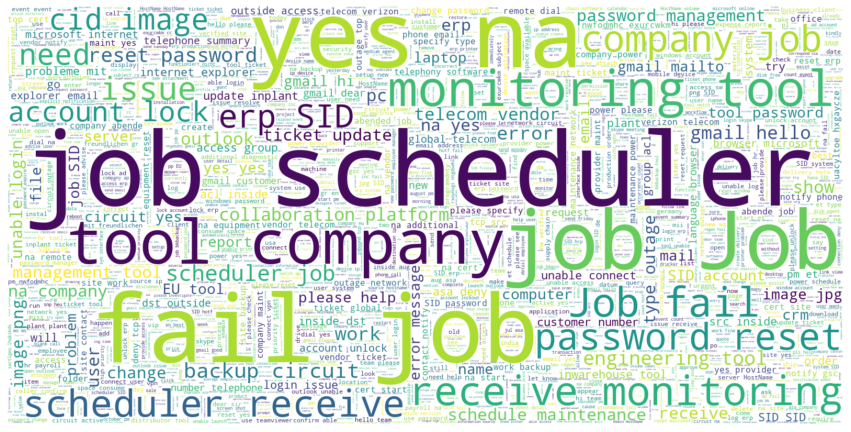

In [ ]:
from wordcloud import WordCloud
text = (final_df['RawDescription']).to_string(index=False)
wordcloud = WordCloud(background_color='white',max_words = 2000 , width = 1600 , height = 800).generate(text)
#wordcloud = WordCloud(background_color='white',max_words = 2000 , width = 1600 , height = 800)
# plot the WordCloud image                        
plt.figure(figsize = (15, 12), facecolor = None) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
final_df['Assignment group']= pd.Categorical(final_df['Assignment group'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
final_df['group'] = pd.factorize(final_df['Assignment group'])[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###TFIDF

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_df['RawDescription'], final_df['group'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

In [ ]:
X_train_counts.shape

(6240, 12151)

In [ ]:
X_train_tfidf.shape

(6240, 12151)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((6240,), (6240,), (2081,), (2081,))

In [ ]:
X_train.head()

5616    unable to open outlook   unable to open outlook                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [ ]:
y_train.head()

5616    0 
7469    20
5147    43
1998    7 
8428    11
Name: group, dtype: int64

###Bagging Classifier

In [ ]:
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve,f1_score
from sklearn.ensemble import BaggingClassifier  

In [ ]:
bgclassifier = BaggingClassifier(n_estimators=150, max_samples= .7, bootstrap=True, oob_score=True, random_state=22) 
bgclassifier = bgclassifier.fit(X_train_tfidf, y_train) 

In [ ]:
y_train_pred_bgc = bgclassifier.predict(count_vect.transform(X_train))
y_test_pred_bgc = bgclassifier.predict(count_vect.transform(X_test))

In [ ]:
print("Bagging Classifier:")
print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred_bgc) * 100))
print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_test_pred_bgc) * 100))

Bagging Classifier:
Training accuracy: 73.86%
Testing accuracy: 58.15%


###KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, accuracy_score, precision_recall_curve,f1_score

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=7,weights='uniform').fit(X_train_tfidf, y_train)
y_train_pred_knn = clf_knn.predict(count_vect.transform(X_train))
y_test_pred_knn = clf_knn.predict(count_vect.transform(X_test))
print("K Nearest Neighbours :")
print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred_knn) * 100))
print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_test_pred_knn) * 100))

K Nearest Neighbours :
Training accuracy: 67.95%
Testing accuracy: 64.87%


###SVM

In [ ]:
from sklearn.svm import SVC, LinearSVC

In [ ]:
clf_svc = LinearSVC().fit(X_train_tfidf, y_train)
y_train_pred_svc = clf_svc.predict(count_vect.transform(X_train))
y_test_pred_svc = clf_svc.predict(count_vect.transform(X_test))
print("Support Vector Machine :")
print('Training accuracy: %.2f%%' % (accuracy_score(y_train,y_train_pred_svc) * 100))
print('Testing accuracy: %.2f%%' % (accuracy_score(y_test, y_test_pred_svc) * 100))

Support Vector Machine :
Training accuracy: 88.81%
Testing accuracy: 68.04%


In [ ]:
from sklearn import model_selection

In [ ]:
# Comparing models
models = []
models.append(('KNN', KNeighborsClassifier(n_neighbors=7)))
models.append(('SVM', LinearSVC()))
models.append(('Bagging Classifier', BaggingClassifier()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
	kfold = model_selection.KFold(n_splits=10)
	cv_results = model_selection.cross_val_score(model, X_train_tfidf, y_train, cv=kfold, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)

KNN: 0.335417 (0.026284)
SVM: 0.683974 (0.013838)
Bagging Classifier: 0.637340 (0.026059)


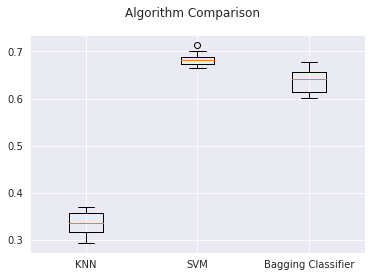

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

###LSTM

In [ ]:
texts = final_df['RawDescription'].values
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
final_df['token_text_vocab'] = tokenizer.texts_to_sequences(texts)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
final_df.head()

Short description  ...                                                                                                                              token_text_vocab
0  login issue                    ...  [53, 32, 303, 30, 176, 206, 135, 59, 105, 3, 30, 59, 4, 243, 14, 31, 3, 18, 281, 3, 30, 1, 53, 14, 105, 410, 258, 55, 2, 96, 1, 53, 32, 187]
1  outlook                        ...  [50, 17, 7, 3402, 3403, 20, 6, 70, 112, 346, 94, 346, 456, 2, 8, 440, 4, 50, 663, 36, 5258, 21, 281, 324, 1, 385, 33, 509]                  
2  cant log in to vpn             ...  [36, 8, 85, 4, 1, 92, 17, 7, 4200, 4201, 20, 6, 128, 15, 36, 8, 85, 11, 1, 92, 195]                                                         
3  unable to access hr_tool page  ...  [34, 1, 35, 161, 12, 331, 34, 1, 35, 161, 12, 331]                                                                                          
4  skype error                    ...  [94, 46, 94, 46]                                                                                                                            

[5 rows x 8 columns]

In [ ]:
vocab_words = tokenizer.word_index.items()
len(vocab_words)

14014

In [ ]:
#Get the vocabulary size
num_words = len(tokenizer.word_index) +1
print (num_words)

14015


In [ ]:
#To view the 10 elements from dictionary
from itertools import islice
def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

take(10, vocab_words)

[('to', 1),
 ('be', 2),
 ('the', 3),
 ('in', 4),
 ('job', 5),
 ('com', 6),
 ('from', 7),
 ('not', 8),
 ('no', 9),
 ('a', 10)]

In [189]:
maxlen=300
max_features = 10000

In [ ]:
train_sequence = tokenizer.texts_to_sequences(final_df['RawDescription'])
X = pad_sequences(train_sequence, padding='post',maxlen = maxlen)

y = pd.get_dummies(final_df['Assignment group']).values

In [ ]:
maxlen = max([len(x) for x in train_sequence])

In [ ]:
maxlen

1572

In [ ]:
print("Number of Samples:", len(X))
print("Number of Labels: ", len(y))

Number of Samples: 8321
Number of Labels:  8321


In [ ]:
final_df.head()

Short description  ...                                                                                                                              token_text_vocab
0  login issue                    ...  [53, 32, 303, 30, 176, 206, 135, 59, 105, 3, 30, 59, 4, 243, 14, 31, 3, 18, 281, 3, 30, 1, 53, 14, 105, 410, 258, 55, 2, 96, 1, 53, 32, 187]
1  outlook                        ...  [50, 17, 7, 3402, 3403, 20, 6, 70, 112, 346, 94, 346, 456, 2, 8, 440, 4, 50, 663, 36, 5258, 21, 281, 324, 1, 385, 33, 509]                  
2  cant log in to vpn             ...  [36, 8, 85, 4, 1, 92, 17, 7, 4200, 4201, 20, 6, 128, 15, 36, 8, 85, 11, 1, 92, 195]                                                         
3  unable to access hr_tool page  ...  [34, 1, 35, 161, 12, 331, 34, 1, 35, 161, 12, 331]                                                                                          
4  skype error                    ...  [94, 46, 94, 46]                                                                                                                            

[5 rows x 8 columns]

In [ ]:
project_path = '/content/drive/My Drive/Colab Notebooks/Project Report/'

In [ ]:
glove_file = project_path + "glove.6B.zip"

In [ ]:
from zipfile import ZipFile
with ZipFile(glove_file, 'r') as z:
  z.extractall()

In [ ]:
EMBEDDING_FILE = './glove.6B.200d.txt'

embeddings = {}
for o in open(EMBEDDING_FILE):
    word = o.split(" ")[0]
    # print(word)
    embd = o.split(" ")[1:]
    embd = np.asarray(embd, dtype='float32')
    # print(embd)
    embeddings[word] = embd

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((num_words, 200))

for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

In [ ]:
len(embeddings.values())

400000

In [ ]:
embeddings['outlook']

array([ 0.25253  ,  0.30753  ,  0.54159  ,  0.0085215,  0.36576  ,
       -0.38342  , -0.002875 , -0.65564  ,  0.55872  ,  0.54463  ,
        0.5221   ,  0.67832  , -0.044136 , -0.45919  ,  1.3775   ,
        0.54288  , -0.05421  ,  0.36371  , -0.059071 , -0.56022  ,
        0.63958  ,  1.5561   , -0.75875  , -0.24567  , -0.099208 ,
        0.32084  , -0.31637  ,  0.51132  , -0.75753  , -0.008595 ,
       -0.47135  , -0.28668  , -0.76088  ,  0.089982 ,  0.82554  ,
       -0.44267  ,  0.017712 , -0.12609  , -0.35306  ,  0.58798  ,
       -0.079643 , -0.09144  , -0.69428  ,  0.7141   ,  0.098986 ,
       -0.15905  ,  0.20222  , -0.26678  , -0.71632  ,  0.14216  ,
       -0.35488  ,  0.66125  ,  0.13997  , -0.36635  , -0.65228  ,
        0.017395 , -0.28262  , -0.62002  , -0.10768  , -0.63378  ,
        0.36728  , -0.25112  , -0.0050054, -0.12513  ,  0.071162 ,
        0.25933  ,  0.46956  ,  0.41959  ,  0.38161  ,  0.33574  ,
        1.2079   ,  1.0156   , -0.33064  ,  0.049285 ,  0.6479

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6656, 1572), (1665, 1572), (6656, 49), (1665, 49))

In [188]:
#parameters used
epochs = 10
batch_size = 64
embedding_size = 200

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=num_words, 
                        output_dim=embedding_size, 
                        weights=[embedding_matrix], 
                        input_length=maxlen, 
#                       mask_zero=True,
                        trainable=False))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(49, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint

In [ ]:
### save the model so that you can use them again
output_dir = 'model_output/LSTM'

modelcheckpoint = ModelCheckpoint(filepath=output_dir+"/weights.{epoch:02d}.hdf5")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
X_train.shape

(6656, 1572)

In [ ]:
y_train.shape

(6656, 49)

In [ ]:
history = model.fit(X_train,  
                    y_train, 
                    epochs=epochs, 
                    batch_size=batch_size,
                    validation_data=(X_test, y_test)
                    )

Epoch 1/10
104/104 [==============================] - 1010s 10s/step - loss: 2.3197 - accuracy: 0.5069 - val_loss: 1.9356 - val_accuracy: 0.5592
Epoch 2/10
104/104 [==============================] - 1013s 10s/step - loss: 1.7693 - accuracy: 0.5750 - val_loss: 1.7091 - val_accuracy: 0.5784
Epoch 3/10
104/104 [==============================] - 1006s 10s/step - loss: 1.5759 - accuracy: 0.5959 - val_loss: 1.5506 - val_accuracy: 0.6078
Epoch 4/10
104/104 [==============================] - 1005s 10s/step - loss: 1.4303 - accuracy: 0.6224 - val_loss: 1.4703 - val_accuracy: 0.6120
Epoch 5/10
104/104 [==============================] - 1002s 10s/step - loss: 1.3343 - accuracy: 0.6385 - val_loss: 1.4262 - val_accuracy: 0.6132
Epoch 6/10
104/104 [==============================] - 1005s 10s/step - loss: 1.2493 - accuracy: 0.6504 - val_loss: 1.3641 - val_accuracy: 0.6330
Epoch 7/10
104/104 [==============================] - 1006s 10s/step - loss: 1.1906 - accuracy: 0.6630 - val_loss: 1.3348 - val_ac

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
acc_test =model.evaluate(X_test,y_test)
print("Test Accuracy:",acc_test[1])

acc_train =model.evaluate(X_train,y_train)
print("Train Accuracy:",acc_train[1])

53/53 [==============================] - 50s 944ms/step - loss: 1.2883 - accuracy: 0.6511
Test Accuracy: 0.6510510444641113
208/208 [==============================] - 204s 980ms/step - loss: 0.8551 - accuracy: 0.7422
Train Accuracy: 0.7421875


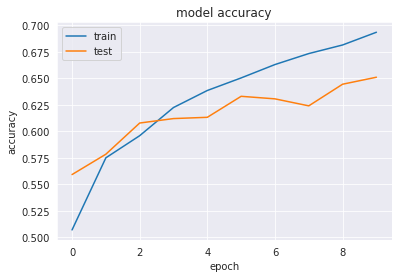

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

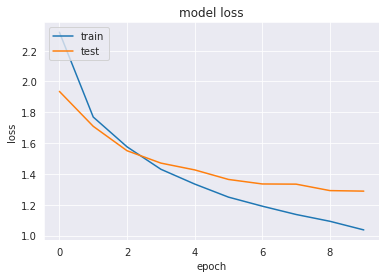

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

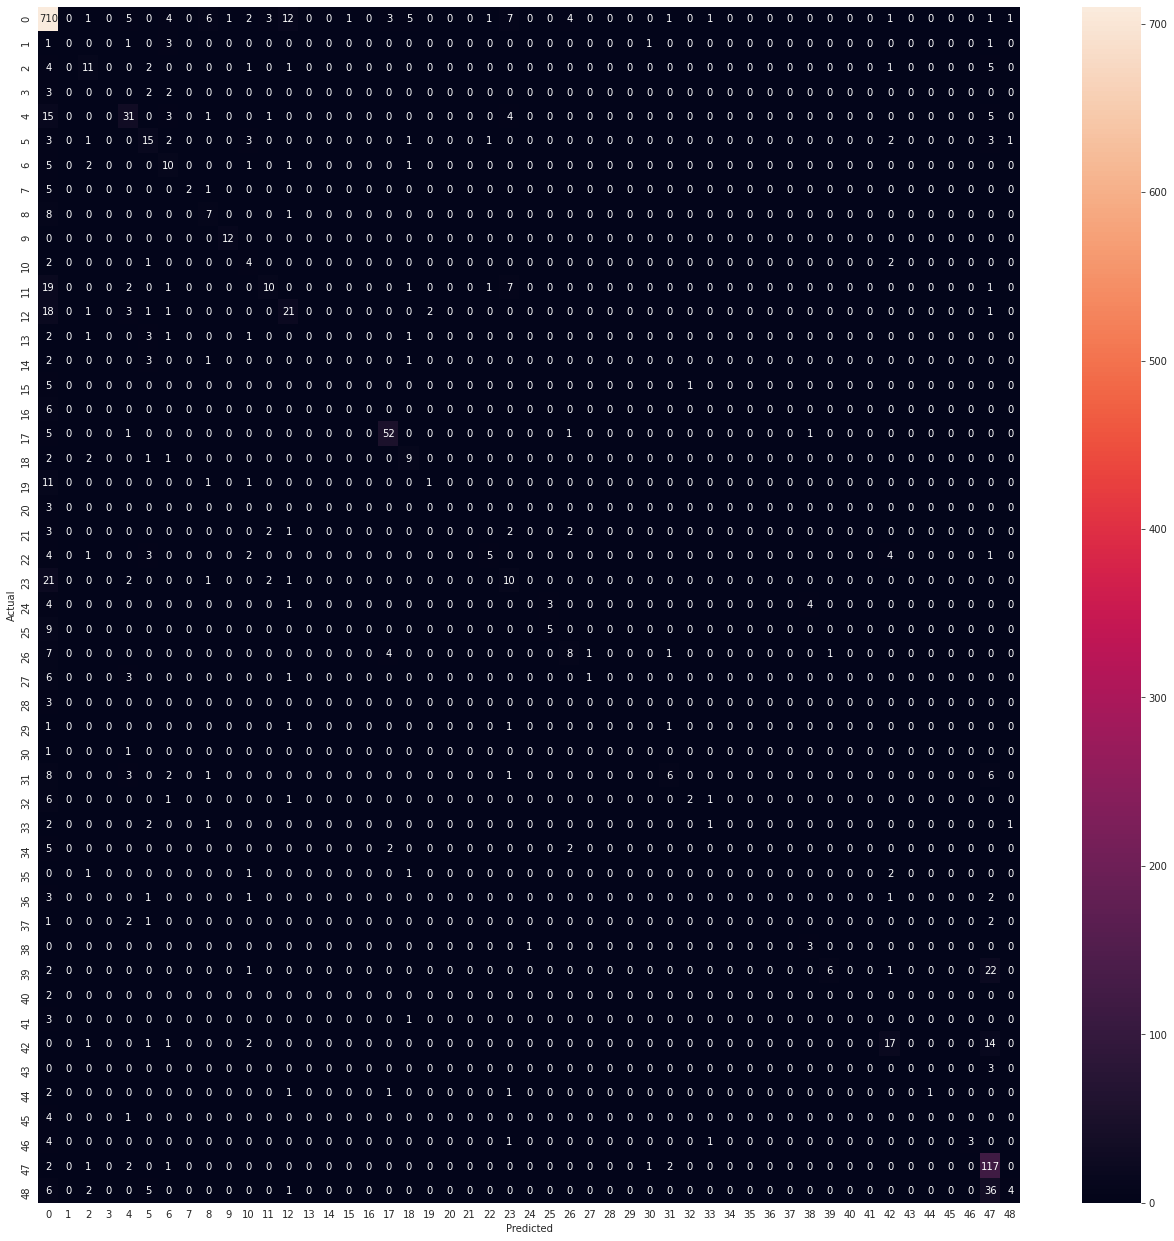

In [ ]:
conf_mat = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))  
#fig, ax = plt.subplots(figsize=(20,20))
plt.figure(figsize=(22,22))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=final_df['group'].unique(), yticklabels=final_df['group'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, auc

In [ ]:
print('Classification report:\n %s' % (classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))))

Classification report:
               precision    recall  f1-score   support

           0       0.76      0.92      0.83       770
           1       0.00      0.00      0.00         7
           2       0.44      0.44      0.44        25
           3       0.00      0.00      0.00         7
           4       0.54      0.52      0.53        60
           5       0.37      0.47      0.41        32
           6       0.30      0.50      0.38        20
           7       1.00      0.25      0.40         8
           8       0.35      0.44      0.39        16
           9       0.92      1.00      0.96        12
          10       0.20      0.44      0.28         9
          11       0.56      0.24      0.33        42
          12       0.48      0.44      0.46        48
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         7
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         6
   

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [170]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1572, 200)         2803000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 1572, 200)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               240800    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 49)                4949      
Total params: 3,068,849
Trainable params: 265,849
Non-trainable params: 2,803,000
______________________________________

In [172]:
ticket = ['I have issue fixing the network problem which was working fine last month']
#vectorizing the tweet by the pre-fitted tokenizer instance
ticket = tokenizer.texts_to_sequences(ticket)
#padding the tweet to have exactly the same shape as `embedding_2` input
ticket = pad_sequences(ticket, maxlen=maxlen, value=0.0, padding='post')
print("Ticket :",ticket)
output = model.predict(ticket)
print("Output:",output)

Ticket : [[15 26 32 ...  0  0  0]]
Output: [[3.48058581e-01 2.59029912e-04 7.99549103e-04 1.25974300e-03
  2.06175935e-03 1.72493642e-03 1.31917803e-03 2.66252144e-04
  1.14151845e-02 1.31802226e-04 7.20456301e-04 1.19521491e-01
  2.79806624e-03 4.73260821e-04 7.27224164e-03 5.08432975e-04
  7.18264747e-03 3.88154178e-04 4.33466816e-03 5.88646578e-03
  7.11645093e-03 7.42796343e-03 1.13814324e-03 3.66924614e-01
  1.07744127e-03 1.02933291e-02 1.20641117e-03 1.09987555e-03
  1.98174897e-03 6.95853261e-03 1.69281324e-04 2.24693920e-02
  9.92655521e-04 5.45088062e-03 4.32484492e-04 7.53762608e-04
  1.96797680e-03 1.53057976e-04 7.44577206e-04 8.81582790e-04
  4.14699921e-03 4.63109463e-04 2.30036472e-04 7.08509528e-04
  2.71967240e-03 1.76724454e-03 2.66002622e-02 1.86404644e-03
  5.87805919e-03]]
